In [1]:
import json 
import numpy as np
import thermocore.io.casm as cio
from djlib.plotting.hull_plotting import general_binary_convex_hull_plotter
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoLarsCV
import thermocore.geometry.hull as thull
import djlib.clex.clex as cl
import pickle
from sklearn.metrics import mean_squared_error

In [2]:
#Load the query data from the json file
with open('ZrN_FCC_1.2.0_8_body_10-5-2022.json') as f:
    query = json.load(f)
data = cio.regroup_query_by_config_property(query)
corr = np.array(data['corr'])
corr_unaltered = np.array(data['corr'])
comp = np.array(data['comp'])
formation_energy = np.array(data['formation_energy'])
name = np.array(data['name'])
print(corr.shape)


(940, 534)


In [3]:
#Often, we will work with a large set of basis functions, and remove basis functions that are not needed. 
#However, CASM will expect an ECI vector that is the same length as the original set of basis functions.
#Maintaining an upscaling vector of booleans allows us to record the basis functions that are removed, and
#reconstruct the original ECI vector when needed.
upscaling_boolean_vector = np.array([True]*corr.shape[1])

In [4]:
#Dealing with a CASM bug: large clusters with multiplicity ==1 produce problems in monte carlo. Remove them from the fit.


#Load the basis.json file to find the multiplicity of each correlation
#Normally, this is located in project_root/basis_sets/bset.default/basis.json
basis_path = 'basis.json'
with open(basis_path) as f:
    basis = json.load(f)
multiplicities = np.array(cio.pull_multiplicity_from_json(basis))
print(np.where(multiplicities == 1))

#Current bug in casm: large clusters with multiplicity ==1 produce problems in monte carlo. 
#Find clusters with multiplicity == 1; if the index is greater than 10, remove, store that index
large_multiplicity_1_clusters = np.where(multiplicities == 1)[0]
large_multiplicity_1_clusters = large_multiplicity_1_clusters[large_multiplicity_1_clusters > 10]
print(large_multiplicity_1_clusters)

#Remove clusters with multiplicity == 1 and index > 10 from corr
upscaling_boolean_vector[large_multiplicity_1_clusters] = False
print(upscaling_boolean_vector.shape)
print(corr.shape)
corr = corr[:,upscaling_boolean_vector]
print(corr.shape)

print('\nLarge clusters with multiplicity == 1 have been removed from corr.')

(array([  0,   1, 312]),)
[312]
(534,)
(940, 534)
(940, 533)

Large clusters with multiplicity == 1 have been removed from corr.


In [5]:
#To find models that replicate DFT ground states, we need to identify the DFT ground states. 
#Additionally, if we want to prioritize models that are close to the convex hull, we need to quantify the distance of each model from the convex hull.
#Hull distances are used for weighted least squares, but they are also used for calculating hull distance correlations. 


#Calculate hull distances for each point
hull = thull.full_hull(compositions=comp, energies=formation_energy)
hull_distances = thull.lower_hull_distances(convex_hull=hull, compositions=comp, energies=formation_energy)

#Calculate true convex hull vertices
true_lower_hull_vertices, _ = thull.lower_hull(hull)
print(true_lower_hull_vertices)
print(comp[true_lower_hull_vertices])

#Calculate hull distance correlations
hull_corr = thull.hull_distance_correlations(corr=corr, compositions=comp, formation_energy=formation_energy, hull=hull)
feature_matrix = np.concatenate((corr, hull_corr), axis=0)
target_values = np.concatenate((formation_energy, hull_distances), axis=0)

[  0   1  27  28 696 809 815 829]
[[1.        ]
 [0.        ]
 [0.5       ]
 [0.25      ]
 [0.81818182]
 [0.85714286]
 [0.78571429]
 [0.71428571]]


In [6]:
#Build the model that we will use to fit the data.
reg = LassoLarsCV(fit_intercept=False, n_jobs=-1, max_iter=50000)

#Weighted leas squares requires a weighting scheme. We will weight by the Boltzmann distribution of the hull distances.
#We must still specify how "aggressively" we want to weight the data. This is done by specifying a "B" value.
#Larger B values will weight the data more aggressively, placing more emphasis on data that is close to the convex hull.
#Specify an array of boltzmann "B" weights to use: linearly spaced from 1 to 300, 100 points
B = np.linspace(1, 300, 500)


In [ ]:
#For each B, calculate the weighted feature and target arrays. 
#Then fit a cluster expansion model with LassoLarsCV
models = []
for b in B:
    #calculate the weighted feature and target vectors
    weight = np.identity(target_values.shape[0])
    for config_index in range(formation_energy.shape[0]):
        weight[config_index, config_index] = cl.boltzmann(
            hulldist=hull_distances[config_index], coef=1, beta=b, temperature=1.05
        )
        weight[config_index+formation_energy.shape[0], config_index+formation_energy.shape[0]] = cl.boltzmann(
            hulldist=hull_distances[config_index], coef=1, beta=b, temperature=1.05
        )
    x_prime, y_prime = cl.general_weighted_feature_and_target_arrays(feature_matrix=feature_matrix, target_array=target_values, weight_matrix=weight)
    
    #fit the model
    reg.fit(x_prime, y_prime)
    models.append(reg.coef_)

models = np.array(models)
print(models.shape)

In [ ]:
#dump the models to a pickle file, just so that we don't have to do this every time we open the notebook.
import pickle
with open('weighted_LassoLarsCV_models.pkl', 'wb') as f:
    pickle.dump(models, f) 

In [7]:
#Load models from the pickle file
with open('weighted_LassoLarsCV_models.pkl', 'rb') as f:
    models = pickle.load(f)

In [8]:
#Calculate the predicted energies for each model 
predicted_energies = corr @ models.T
predicted_energies = predicted_energies.T
print(predicted_energies.shape)

(500, 940)


In [9]:
#For each row in the predicted energies array, compute: 
#rmse, ground_state_accuracy_metric, ground_state_fraction_correct, gsa_fraction_correct_DFT_mu_window_binary, gsa_intersection_over_union, complexity

rmse = []
gsa = []
gsf = []
gsad = []
gsu = []
complexity = []

for index, row in enumerate(predicted_energies):
    #calculate predicted ground state indices
    predicted_hull = thull.full_hull(compositions=comp, energies=row)
    predicted_lower_hull_vertices, _ = thull.lower_hull(predicted_hull)

    #calculate the rmse
    rmse.append(np.sqrt(mean_squared_error(formation_energy, row)))
    #calculate the ground state accuracy metric
    gsa.append(cl.ground_state_accuracy_metric(comp, row, true_lower_hull_vertices))
    #calculate the ground state fraction correct
    gsf.append(cl.ground_state_accuracy_fraction_correct(predicted_lower_hull_vertices, true_lower_hull_vertices))
    #calculate the ground state accuracy metric with a DFT mu window
    gsad.append(cl.gsa_fraction_correct_DFT_mu_window_binary(comp, row, comp, formation_energy))
    #calculate the ground state intersection over union
    gsu.append(cl.gsa_fraction_intersection_over_union(predicted_lower_hull_vertices, true_lower_hull_vertices))
    #calculate the model complexity: number of nonzero ECI
    complexity.append(np.count_nonzero(models[index,:])/len(models[index,:]))


#Place all of the metrics into a dataframe
import pandas as pd
df = pd.DataFrame({'rmse':rmse, 'gsa':gsa, 'gsf':gsf, 'gsad':gsad, 'gsu':gsu, 'complexity':complexity})
df['B'] = B

Max error:  0.04113009370912795  eV


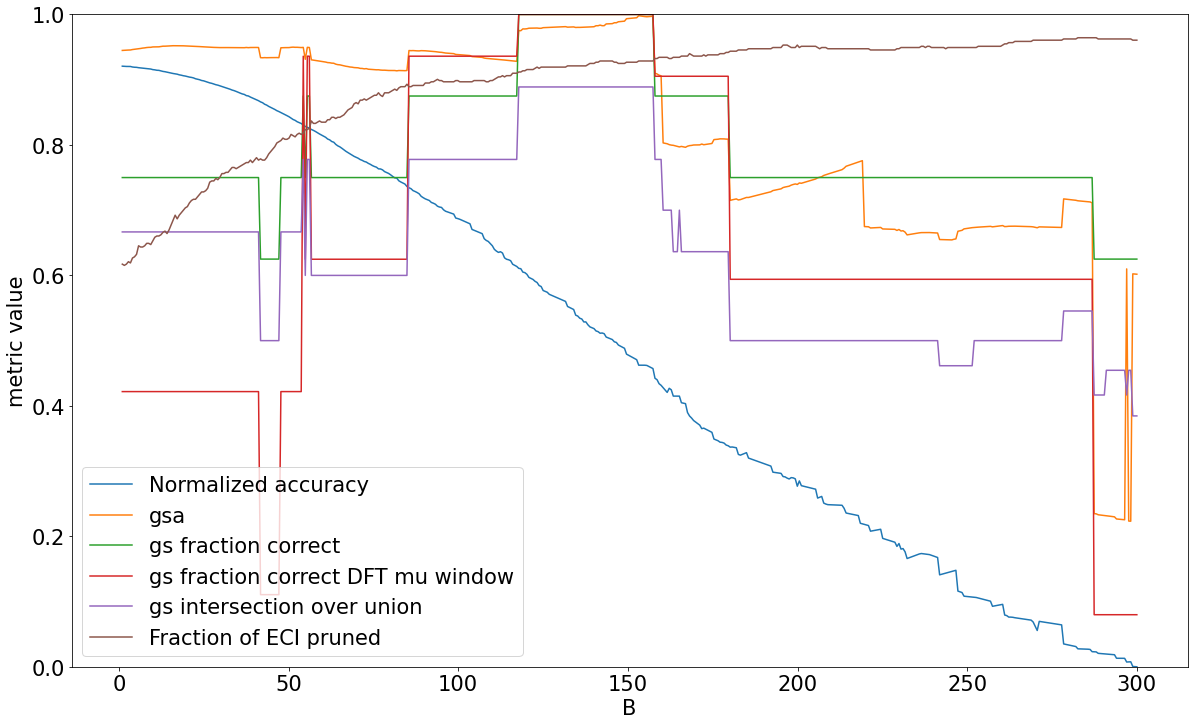

In [10]:
#Plot all metrics vs B


fig, ax = plt.subplots(1, 1, figsize=(20, 12))
print('Max error: ', max(df['rmse']),' eV')

ax.plot(df['B'], 1-np.array(df['rmse'])/max(df['rmse']), label='Normalized accuracy')
ax.plot(df['B'], df['gsa'], label='gsa')
ax.plot(df['B'], df['gsf'], label='gs fraction correct')
ax.plot(df['B'], df['gsad'], label='gs fraction correct DFT mu window')
ax.plot(df['B'], df['gsu'], label='gs intersection over union')
ax.plot(df['B'], 1-np.array(df['complexity']), label='Fraction of ECI pruned')
ax.set_xlabel('B', fontsize=21)
ax.set_ylabel('metric value', fontsize=21)
ax.legend(fontsize=21)
plt.ylim([0,1])
plt.xticks(fontsize=21)
plt.yticks(fontsize=21)

plt.show()

92 0.6057121496085776


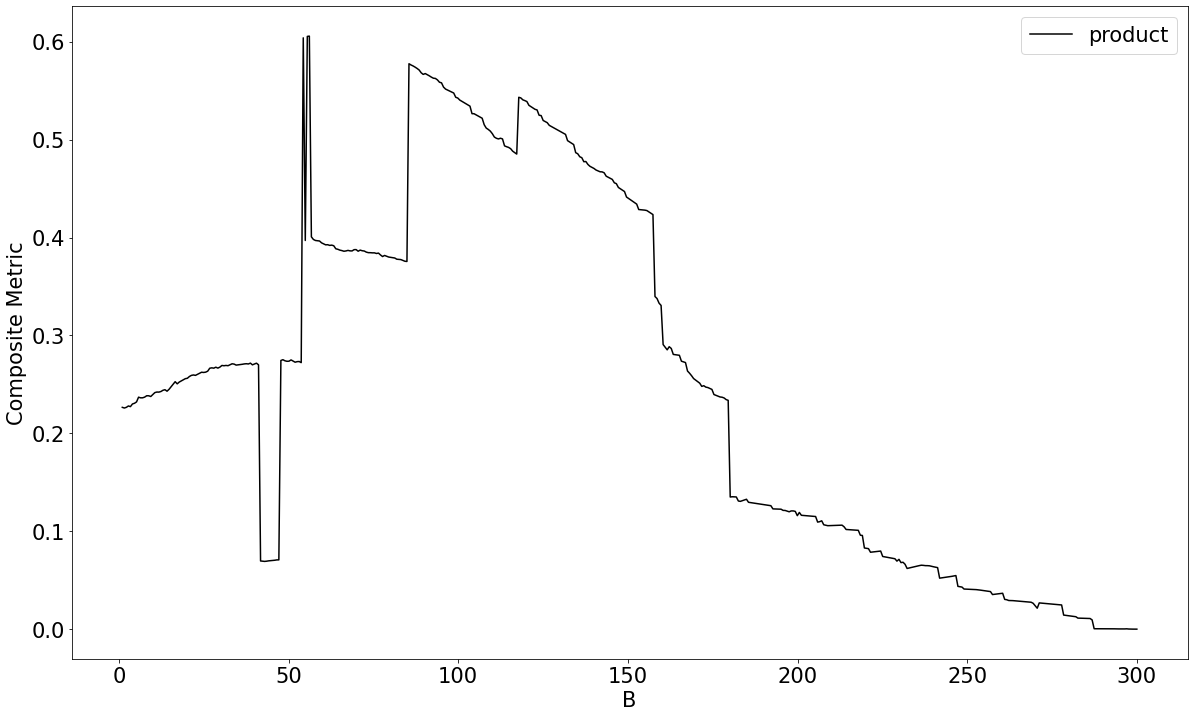

In [11]:
#We are primarily interested in four metrics:
#1. Fraction correct, weighted by stable chemical potential window. This is labelled 'gsad' in the dataframe.
#2. Intersection over union, weighted by stable chemical potential window. This is labelled 'gsa' in the dataframe.
#3. Normalized accuracy.
#4. Fraction of ECI pruned.
#All of these metrics are normalized [0,1], where 1 is the best possible value.
#Create a composite metric by multiplying the four metrics together, and then plot the result vs B.

df['product'] = df['gsa'] * df['gsad'] * (1-np.array(df['complexity'])) * (1-np.array(df['rmse'])/max(df['rmse']))
print(np.argmax(df['product']), max(df['product']))
fig, ax = plt.subplots(1, 1, figsize=(20, 12))
ax.plot(df['B'], df['product'], label='product', color='k')
ax.set_xlabel('B', fontsize=21)
ax.set_ylabel('Composite Metric', fontsize=21)
plt.xticks(fontsize=21)
plt.yticks(fontsize=21)
ax.legend(fontsize=21)
plt.show()

In [12]:
#find the  maximum value of the combined metric and the corresponding B
max_index = df['product'].idxmax()
max_value = df['product'].max()
max_B = df['B'].iloc[max_index]
print(max_value, max_B, max_index)


#Rank the modls by the combined metric: print the indices of the top 10 models, just in case you want to look at them.
print(df.sort_values(by=['product'], ascending=False).head(10))

0.6057121496085776 56.12625250501002 92
         rmse       gsa    gsf      gsad       gsu  complexity          B  \
92   0.007171  0.949377  0.875  0.936057  0.777778    0.174484  56.126253   
91   0.007117  0.949630  0.875  0.936057  0.777778    0.176360  55.527054   
89   0.006963  0.949537  0.875  0.936057  0.777778    0.181989  54.328657   
141  0.010925  0.944725  0.875  0.936057  0.777778    0.110694  85.486974   
142  0.010986  0.944521  0.875  0.936057  0.777778    0.110694  86.086172   
143  0.011105  0.944678  0.875  0.936057  0.777778    0.108818  86.685371   
144  0.011160  0.944418  0.875  0.936057  0.777778    0.108818  87.284569   
145  0.011226  0.944234  0.875  0.936057  0.777778    0.108818  87.883768   
146  0.011306  0.944145  0.875  0.936057  0.777778    0.108818  88.482966   
147  0.011465  0.944547  0.875  0.936057  0.777778    0.108818  89.082164   

      product  
92   0.605712  
91   0.605445  
89   0.603977  
141  0.577534  
142  0.576255  
143  0.575268  


There are 93 non-zero coefficients in the model
0.9360569784676606


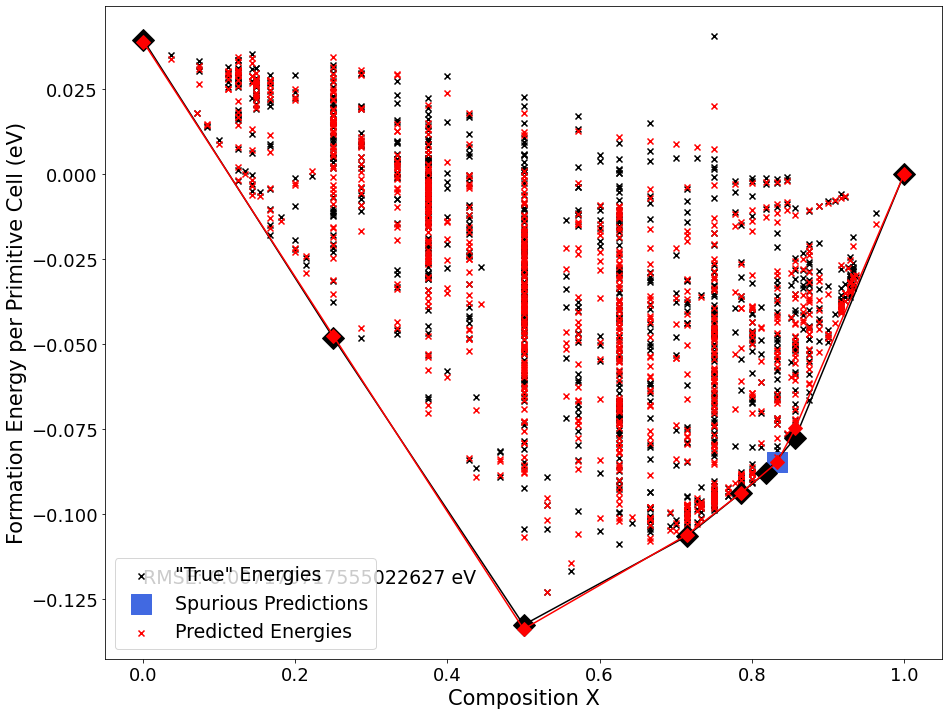

In [13]:
#Find the model with the maximum value of the combined metric
max_model = models[max_index]

#Add a manual override for the maximum index, in case you want to look at a specific model
manual_max_index =False #48
if manual_max_index is not False:
    max_model = models[manual_max_index]
    max_index = manual_max_index

#Visualize the optimal model
print('There are {} non-zero coefficients in the model'.format(np.count_nonzero(max_model)))
from djlib.plotting.hull_plotting import general_binary_convex_hull_plotter
print(cl.gsa_fraction_correct_DFT_mu_window_binary(comp, predicted_energies[max_index], comp, formation_energy))

fig = general_binary_convex_hull_plotter(comp, formation_energy, predicted_energies=predicted_energies[max_index])
fig.set_size_inches(15,12)
plt.show()

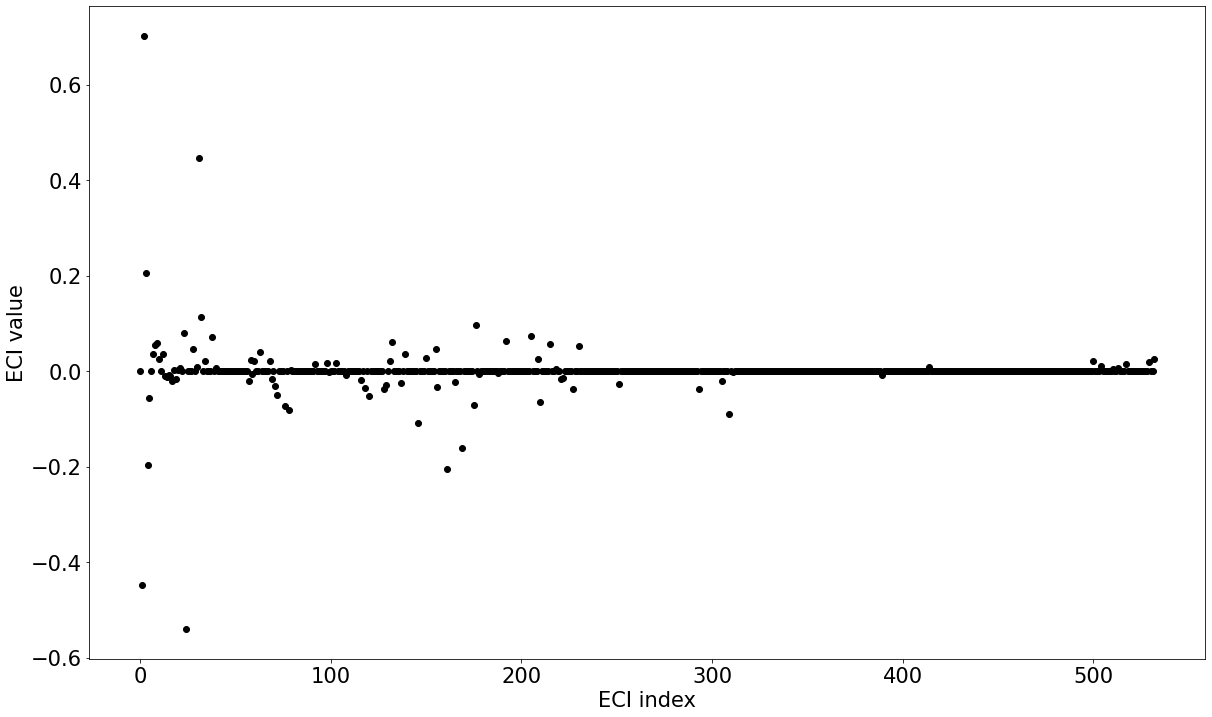

In [14]:
#Visualize the ECI of the optimal model
plt.scatter(list(range(max_model.shape[0])), max_model, color='k')
fig = plt.gcf()
fig.set_size_inches(20, 12)
plt.xticks(fontsize=21)
plt.yticks(fontsize=21)
plt.xlabel('ECI index', fontsize=21)
plt.ylabel('ECI value', fontsize=21)
plt.show()

In [15]:
#Once a prior mean is decided, optimize across the prior variance, which will be called eci_stddev_values. 
import djlib.djlib as dj
eci_stddev_values = np.linspace(0.001, 0.1, 100)         #stddev in eV
prior_mean = max_model
likelihood_stddev = 0.005                               #stddev in eV

#Collect all indices of nonzero coefficients and store them in an array called nonzero_indices
#The prior mean must first be upscaled back to the original feature size (because of the casm bug)
full_dimension_prior_mean = cio.upscale_eci_vector(prior_mean, upscaling_boolean_vector)
print(full_dimension_prior_mean.shape)

(534,)


In [16]:
#Find the coefficient indices that have been pruned. Store them to allow later upscaling
zero_indices = np.where(full_dimension_prior_mean == 0)[0]
zeroed_upscaling_boolean_vector = np.copy(upscaling_boolean_vector)
zeroed_upscaling_boolean_vector[zero_indices] = False


#downsample the correlation matrix to only include nonzero coefficients
corr_nonzero = corr_unaltered[:, np.where(zeroed_upscaling_boolean_vector)[0]]
print(corr_nonzero.shape)

#downsample the prior mean to only include nonzero coefficients
prior_mean_nonzero = full_dimension_prior_mean[np.where(zeroed_upscaling_boolean_vector)[0]]
print(prior_mean_nonzero.shape)

(940, 93)
(93,)


In [17]:
#calculate posterior means for each value of the prior standard deviation
posterior_means = []
for index, eci_stddev in enumerate(eci_stddev_values):
    prior_covariance = np.eye(prior_mean_nonzero.shape[0]) * eci_stddev**2
    likelihood_covariance = np.eye(corr_nonzero.shape[0]) * likelihood_stddev**2
    posterior_mean, posterior_covariance = dj.analytic_posterior(feature_matrix=corr_nonzero,
    weight_covariance_matrix=prior_covariance,
    weight_mean_vec=prior_mean_nonzero, 
    label_vec=formation_energy, 
    label_covariance_matrix=likelihood_covariance)
    posterior_means.append(posterior_mean)

posterior_means = np.array(posterior_means)

In [18]:
#Get all predicted energies for each row in posterior means
predicted_energies = corr_nonzero @ posterior_means.T
predicted_energies = predicted_energies.T

#For each row in posterior means, calculate all ground state accuracy metrics and rmse as a function of eci_stddev_values
gsa = []
gsf = []
gsad = []
gsu = []
rmse = []
for row in predicted_energies:
    predicted_hull = thull.full_hull(compositions=comp, energies=row)
    predicted_lower_hull_vertices, _ = thull.lower_hull(predicted_hull)

    #calculate the rmse
    rmse.append(np.sqrt(mean_squared_error(formation_energy, row)))
    #calculate the ground state accuracy metric
    gsa.append(cl.ground_state_accuracy_metric(comp, row, true_lower_hull_vertices))
    #calculate the ground state fraction correct
    gsf.append(cl.ground_state_accuracy_fraction_correct(predicted_lower_hull_vertices, true_lower_hull_vertices))
    #calculate the ground state accuracy metric with a DFT mu window
    gsad.append(cl.gsa_fraction_correct_DFT_mu_window_binary(comp, row, comp, formation_energy))
    #calculate the ground state intersection over union
    gsu.append(cl.gsa_fraction_intersection_over_union(predicted_lower_hull_vertices, true_lower_hull_vertices))

#Place all of the metrics into a dataframe
import pandas as pd
df = pd.DataFrame({'rmse':rmse, 'gsa':gsa, 'gsf':gsf, 'gsad':gsad, 'gsu':gsu})
df['eci_stddev'] = eci_stddev_values

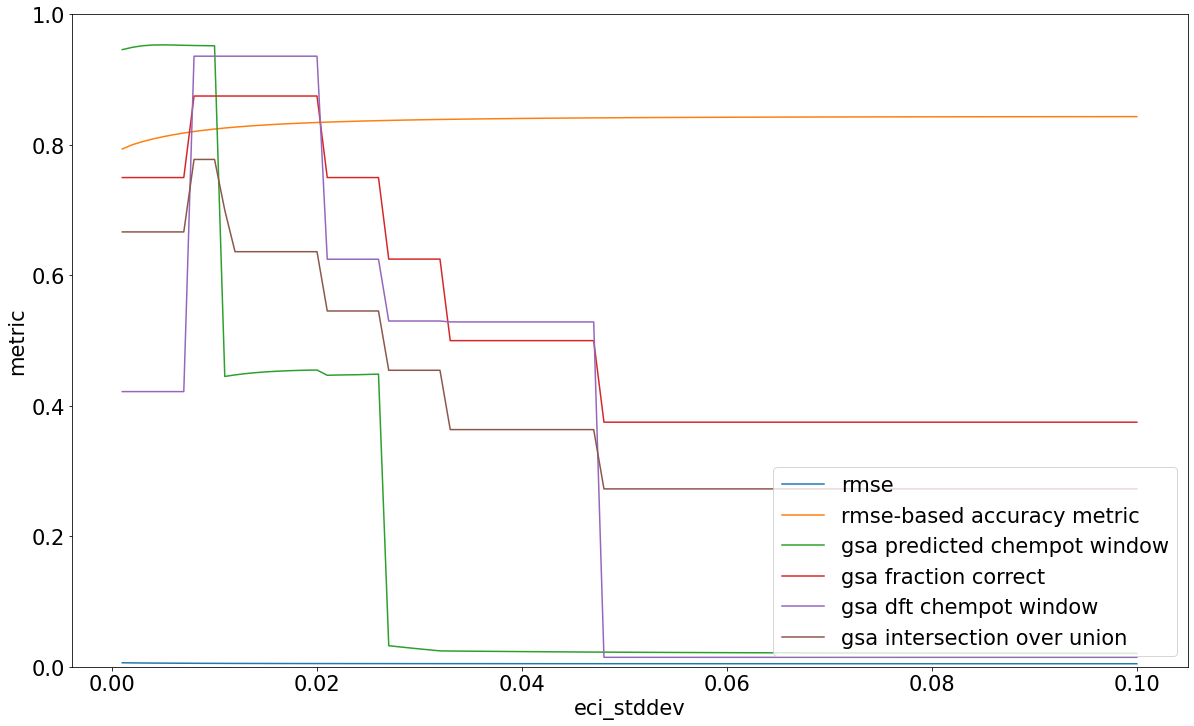

In [19]:
#Plot all of the metrics vs eci_stddev
rmse_max_tolerance = 0.03

fig, ax = plt.subplots(1, 1, figsize=(20, 12))
ax.plot(df['eci_stddev'], df['rmse'], label='rmse')
ax.plot(df['eci_stddev'], (1-np.array(df['rmse'])/rmse_max_tolerance), label='rmse-based accuracy metric')
ax.plot(df['eci_stddev'], df['gsa'], label='gsa predicted chempot window')
ax.plot(df['eci_stddev'], df['gsf'], label='gsa fraction correct')
ax.plot(df['eci_stddev'], df['gsad'], label='gsa dft chempot window ')
ax.plot(df['eci_stddev'], df['gsu'], label='gsa intersection over union')
ax.set_xlabel('eci_stddev', fontsize=21)
ax.set_ylabel('metric', fontsize=21)
ax.legend(fontsize=21, loc='lower right')
plt.xticks(fontsize=21)
plt.yticks(fontsize=21)
plt.ylim([0,1])
plt.show()

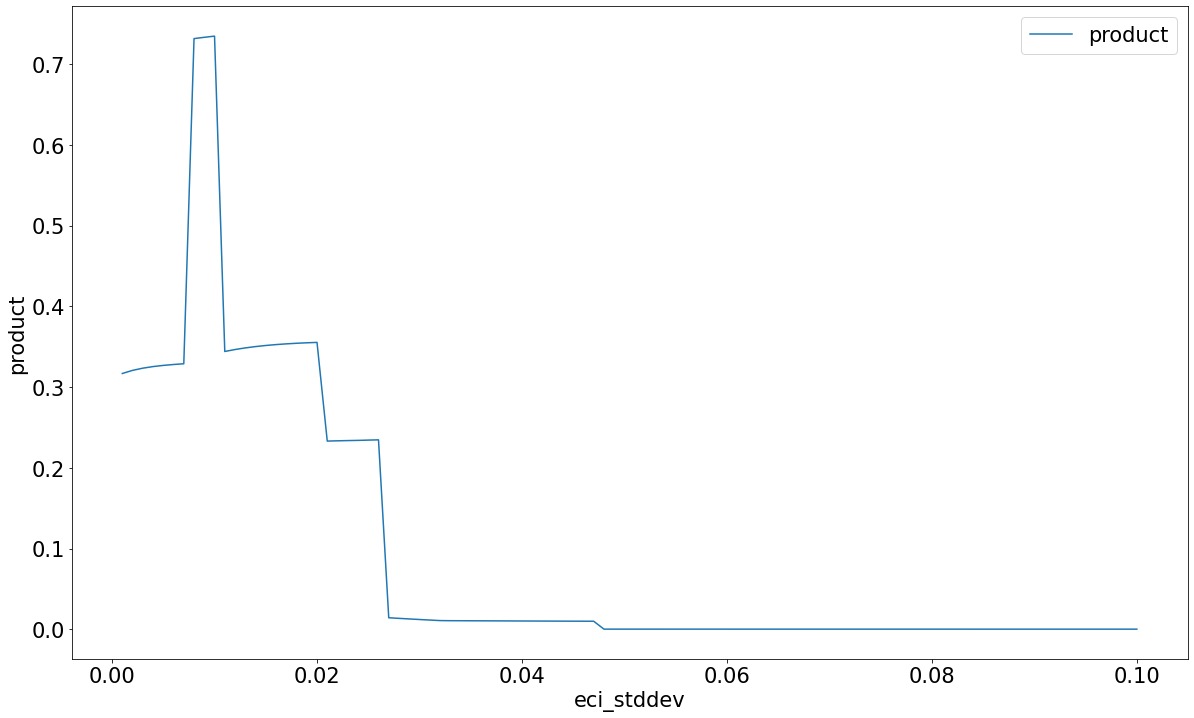

In [20]:
#Plot the product of all of the metrics vs eci_stddev
df['product'] = df['gsa'] * df['gsad'] * (1-np.array(df['rmse'])/rmse_max_tolerance)
fig, ax = plt.subplots(1, 1, figsize=(20, 12))
ax.plot(df['eci_stddev'], df['product'], label='product')
ax.set_xlabel('eci_stddev', fontsize=21)
ax.set_ylabel('product', fontsize=21)
ax.legend(fontsize=21)
plt.xticks(fontsize=21)
plt.yticks(fontsize=21)
plt.show()

In [21]:
#Find the argmax of the product, find the corresponding eci_stddev
optimal_eci_stddev = np.argmax(df['product'])
print(df['eci_stddev'][optimal_eci_stddev])

0.010000000000000002


In [22]:
#Calculate the posterior distribution using the optimal eci_stddev
prior_covariance = np.eye(prior_mean_nonzero.shape[0]) * df['eci_stddev'][optimal_eci_stddev]**2
likelihood_covariance = np.eye(corr_nonzero.shape[0]) * likelihood_stddev**2
posterior_mean, posterior_covariance = dj.analytic_posterior(feature_matrix=corr_nonzero, 
weight_covariance_matrix=prior_covariance,
weight_mean_vec=prior_mean_nonzero, 
label_vec=formation_energy, 
label_covariance_matrix=likelihood_covariance)

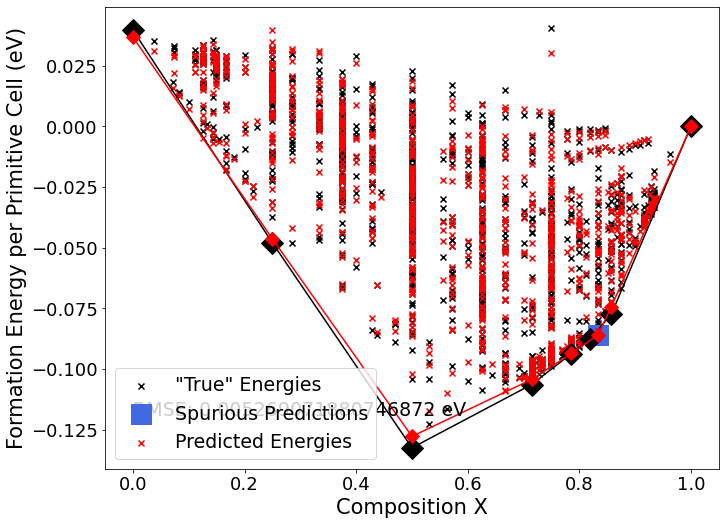

In [23]:
#Visualize the posterior mean model
fig = general_binary_convex_hull_plotter(composition=comp, true_energies=formation_energy, predicted_energies=corr_nonzero@posterior_mean)
plt.show()

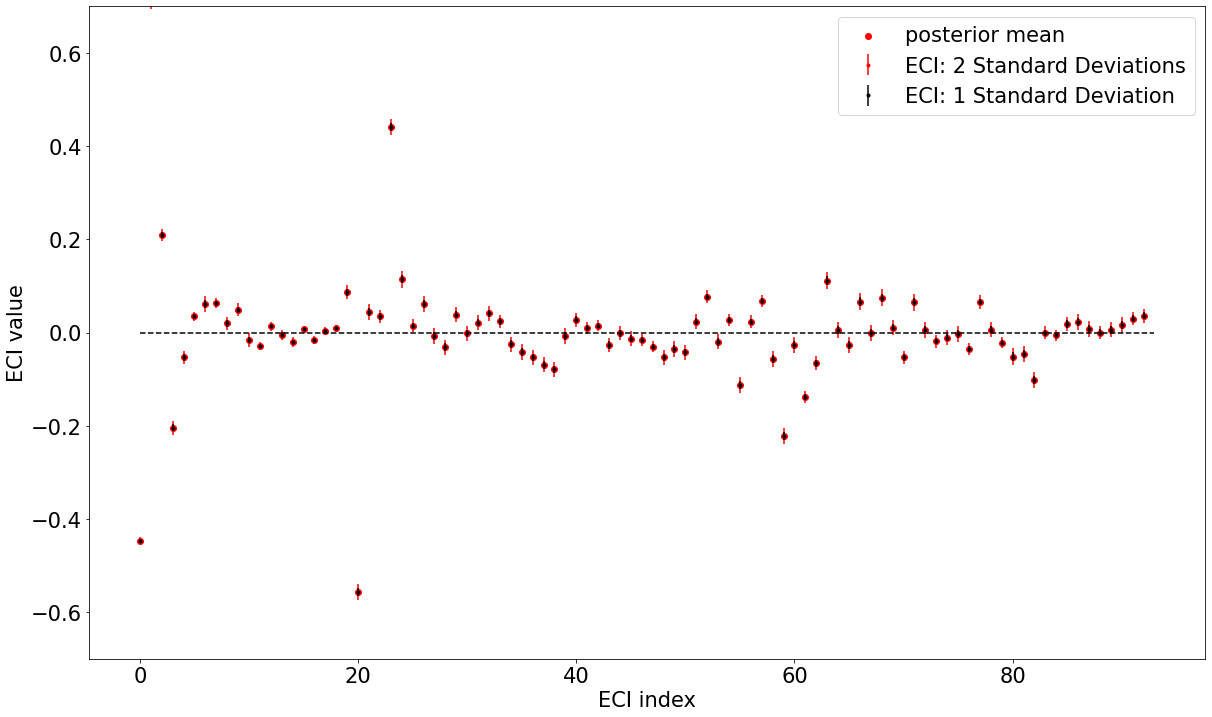

In [24]:
#Visualize the uncertainty in the posterior model
plt.errorbar(x=list(range(len(posterior_mean))),
    y=posterior_mean,
    yerr=2*np.power(np.diag(posterior_covariance),.5),
    fmt='.',
    color='r',
    label='ECI: 2 Standard Deviations')
plt.errorbar(x=list(range(len(posterior_mean))),
    y=posterior_mean,  
    yerr=np.power(np.diag(posterior_covariance),.5), 
    fmt='.', 
    color='k', 
    label='ECI: 1 Standard Deviation')
plt.scatter(list(range(len(posterior_mean))), posterior_mean, color='r', label='posterior mean')
plt.ylim([-.7,0.7])
plt.hlines(y=0, xmin=0, xmax=len(posterior_mean), linestyles='--', color='k')
plt.legend(fontsize=21)
plt.xticks(fontsize=21)
plt.yticks(fontsize=21)
plt.xlabel('ECI index', fontsize=21)
plt.ylabel('ECI value', fontsize=21)
fig = plt.gcf()
fig.set_size_inches(20,12)
plt.show()

In [ ]:
#Write the posterior mean, posterior covariance matrix and upscaling vector to a json file
import json
with open('posterior_mean_weighted_LS_with_hullcorr.json', 'w') as f:
    write_dict = {}
    write_dict['posterior_mean'] = posterior_mean.tolist()
    write_dict['posterior_covariance'] = posterior_covariance.tolist()
    write_dict['upscaling_vector'] = zeroed_upscaling_boolean_vector.tolist()
    json.dump(write_dict, f)

